# The Distribution of Wealth and the MPC


This notebook presents a selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit. It sketches the steps that would need to be taken to solve the model using the [dolARK](https://github.com/EconForge/dolARK) modeling system.


In [1]:
# This cell does some standard python setup!

import os  # Tools for navigating the filesystem
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

import Code.SetupParamsCSTW as Params
from Code.cstwMPC_MAIN import estimate
from Code.SetupParamsCSTW import SCF_wealth, SCF_weights

warnings.filterwarnings("ignore")


def mystr(number):
    return "{:.4f}".format(number)


## Abstract

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, this paper shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. The hegerogeneity-augmented model's predictions are consistent with microeconomic evidence that suggests that the annual marginal propensity to consume (MPC) is much larger than the roughly 0.04 implied by commonly-used macroeconomic models (even ones including some heterogeneity). The high MPC arises because many consumers hold little wealth despite having a strong precautionary motive. The model also plausibly predicts that the aggregate MPC can differ greatly depending on how the shock is distributed across households (depending, e.g., on their wealth, or employment status).


## Notation For the Core Model

We define the following notation.

|    Exogenous Random Variable     | Description       | Code            | Value |
| :------------------------------: | ----------------- | --------------- | :---: |
| $\newcommand{\tshk}{\zeta}\tshk$ | Transitory Income | $\texttt{tshk}$ |       |
| $\newcommand{\pshk}{\psi}\pshk$  | Permanent Shock   | $\texttt{pshk}$ |       |

|                Parameter                 | Description                          | Code                  |  Value  |
| :--------------------------------------: | ------------------------------------ | --------------------- | :-----: |
| $\newcommand{\PLives}{\Lambda} \PLives$  | Probability of living                | $\texttt{PLives}$     | 0.99375 |
| $\newcommand{\Discount}{\beta}\Discount$ | Time Preference Factor               | $\texttt{Discount}$   |  0.96   |
|     $\newcommand{\CRRA}{\rho}\CRRA$      | Coeﬃcient of Relative Risk Aversion  | $\texttt{CRRA}$       |    1    |
|              $\sigma_\tshk$              | Transitory Income Standard Deviation | $\texttt{PermShkStd}$ |   0.1   |
|              $\sigma_\pshk$              | Permanent Shock Standard Deviation   | $\texttt{TranShkStd}$ |   0.1   |

|                 Variable                  | Description         | Code                |
| :---------------------------------------: | ------------------- | ------------------- |
|       $\newcommand{\aRat}{a}\aRat$        | Assets              | $\texttt{aRat}$     |
|       $\newcommand{\mRat}{m}\mRat$        | Market resources    | $\texttt{mRt}$      |
|       $\newcommand{\KLev}{K}\KLev$        | Capital Aggregate   | $\texttt{KLev}$     |
| $\newcommand{\kapShare}{\alpha}\kapShare$ | Capital share       | $\texttt{kapShare}$ |
|       $\newcommand{\LLev}{L}\LLev$        | Labor Aggregate     | $\texttt{LLev}$     |
|     $\newcommand{\labor}{\ell}\labor$     | Labor share         | $\texttt{labor}$    |
|       $\newcommand{\kRat}{k}\kRat$        | $K/P$               | $\texttt{kRat}$     |
|       $\newcommand{\pRat}{p}\pRat$        | Permanent Income    |                     |
|               $\mathbf{P}$                |                     |                     |
|      $\newcommand{\rProd}{r}\rProd$       | Interest rate       | $\texttt{rProd}$    |
|       $\newcommand{\yLev}{y} \yLev$       | Income              | $\texttt{yLev}$     |
|       $\newcommand{\Wage}{W}\Wage$        | Aggregate Wage Rate | $\texttt{Wage}$     |

|                 Functions                 | Description | Code             | Value |
| :---------------------------------------: | ----------- | ---------------- | :---: |
|  $\newcommand{\cFunc}{\mathrm{c}}\cFunc$  | Consumption | $\texttt{cFunc}$ |       |
| $\newcommand{\valfn}{\mathrm{v}} \valfn$  | Value       | $\texttt{valfn}$ |
| $\newcommand{\uFunc}{{\mathrm{u}}}\uFunc$ | Utility     | $\texttt{uFunc}$ |       |

$\newcommand{\cRat}{c}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\PDies}{\mathsf{P}}$
$\newcommand{\ptyLev}{a}$
$\newcommand{\YLev}{Y}$
$\newcommand{\wEndRat}{\aRat}$


The consumer has a standard Constant Relative Risk Aversion utility function $$u(c)=\frac{c^{1-\rho}}{1-\rho}$$


The idiosyncratic (household) income process is logarithmic Friedman:
\begin{align*}
\yLev_{t+1} & = \pRat_{t+1}\tshk_{t+1}\Wage\\
\pRat_{t+1} & = \pRat_{t}\pshk_{t+1}
\end{align*}


The Bellman form of the value function for households is:

\begin{align*}
\valfn(\mRat_{t}) & = \underset{\cFunc_{t}}{\max } ~~ \uFunc(\cFunc_{t}(\mRat_{t}))+\Discount \PLives \Ex_{t}\left[ \pshk_{t+1}^{1-\CRRA}\valfn(\mRat_{t+1})
\right] \\
\notag & \text{s.t.}\\
\wEndRat_{t} & = \mRat_{t}-\cRat_{t},\\
\wEndRat_{t} & \geq0, \\
\kRat_{t+1} & = \wEndRat_{t}/(\PLives \pshk_{t+1}),
\\
\mRat_{t+1} & = (\daleth +\rProd_{t})\kRat_{t+1}+\tshk_{t+1},\\
\rProd & = \kapShare\ptyLev(\KLev/\labor\LLev)^{\kapShare-1}\\
\end{align*}


In [2]:
"""
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
"""

"""
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
"""

here = os.path.dirname(os.path.realpath("cstwMPC.ipynb"))
my_path = os.path.join(here, "")
path_to_models = os.path.join(my_path, "Code")

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "DiscFac"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

GPFRaw                 = 0.965535 


GPFNrm                 = 0.968688 


GPFAggLivPrb           = 0.959500 


Thorn = APF            = 0.965535 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.944063 


WRPF                   = 0.066084 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


Beginning an estimation with the specification name PYbetaPointIndNetWorth...
0.95


GPFRaw                 = 1.011270 


GPFNrm                 = 1.014574 


GPFAggLivPrb           = 1.004950 


Thorn = APF            = 1.011270 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.988781 


WRPF                   = 0.069215 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.95 and got -9.743386134287636
0.995


GPFRaw                 = 0.971401 


GPFNrm                 = 0.974574 


GPFAggLivPrb           = 0.965330 


Thorn = APF            = 0.971401 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.949798 


WRPF                   = 0.066486 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.995 and got 66.22097507353837
0.9557718167976613


GPFRaw                 = 0.991336 


GPFNrm                 = 0.994574 


GPFAggLivPrb           = 0.985140 


Thorn = APF            = 0.991336 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.969290 


WRPF                   = 0.067850 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9557718167976613 and got -9.689812141385481
0.9753859083988307


GPFRaw                 = 1.001303 


GPFNrm                 = 1.004574 


GPFAggLivPrb           = 0.995045 


Thorn = APF            = 1.001303 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.979035 


WRPF                   = 0.068532 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9753859083988307 and got -9.312378927936585
0.9851929541994153


GPFRaw                 = 1.006287 


GPFNrm                 = 1.009574 


GPFAggLivPrb           = 0.999997 


Thorn = APF            = 1.006287 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.983908 


WRPF                   = 0.068874 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9851929541994153 and got -8.224801113627697
0.9900964770997076


GPFRaw                 = 1.004313 


GPFNrm                 = 1.007594 


GPFAggLivPrb           = 0.998036 


Thorn = APF            = 1.004313 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.981979 


WRPF                   = 0.068739 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9900964770997076 and got 5.392169106610039
0.9881547364430956


GPFRaw                 = 1.005159 


GPFNrm                 = 1.008442 


GPFAggLivPrb           = 0.998877 


Thorn = APF            = 1.005159 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.982806 


WRPF                   = 0.068796 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9881547364430956 and got -4.042940744132995
0.9889867715268776


GPFRaw                 = 1.005311 


GPFNrm                 = 1.008595 


GPFAggLivPrb           = 0.999028 


Thorn = APF            = 1.005311 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.982955 


WRPF                   = 0.068807 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9889867715268776 and got -0.6825857330523828
0.9891367912751661


GPFRaw                 = 1.005304 


GPFNrm                 = 1.008587 


GPFAggLivPrb           = 0.999021 


Thorn = APF            = 1.005304 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.982947 


WRPF                   = 0.068806 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891367912751661 and got 0.03615625328873584
0.9891292445447392


GPFRaw                 = 1.005304 


GPFNrm                 = 1.008588 


GPFAggLivPrb           = 0.999021 


Thorn = APF            = 1.005304 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.982948 


WRPF                   = 0.068806 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891292445447392 and got -0.0007644186573134704
0.9891297445447396


GPFRaw                 = 1.005304 


GPFNrm                 = 1.008587 


GPFAggLivPrb           = 0.999021 


Thorn = APF            = 1.005304 


PermGroFacAdj          = 0.996744 


uInvEpShkuInv          = 1.000000 


VAF                    = 0.982947 


WRPF                   = 0.068806 


DiscFacGPFNrmMax       = 0.980708 


DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891297445447396 and got 0.0016792119110959902
0.9891292445447392


Estimate is center=0.9891292445447392, spread=0.0, took 52.727304458618164 seconds.
Running in interactive shell (Jupyter notebook or spyder)


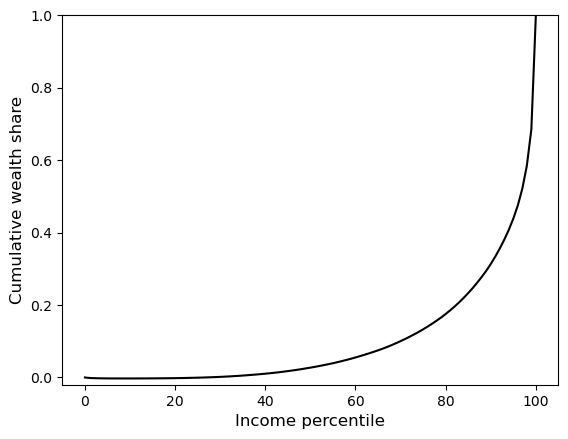

Estimate is center=0.9891292445447392, spread=0.0
Lorenz distance is 42.338843698742544
Average MPC for all consumers is 0.099
Average MPC in the top percentile of W/Y is 0.069
Average MPC in the top decile of W/Y is 0.071
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.074
Average MPC in the middle quintile of W/Y is 0.074
Average MPC in the fourth quintile of W/Y is 0.076
Average MPC in the bottom quintile of W/Y is 0.197
Average MPC in the top percentile of y is 0.075
Average MPC in the top decile of y is 0.077
Average MPC in the top quintile of y is 0.084
Average MPC in the second quintile of y is 0.117
Average MPC in the middle quintile of y is 0.119
Average MPC in the fourth quintile of y is 0.082
Average MPC in the bottom quintile of y is 0.092
Average MPC for the employed is 0.096
Average MPC for the unemployed is 0.130
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
65.752% are in the bottom wealt

In [4]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, Params)

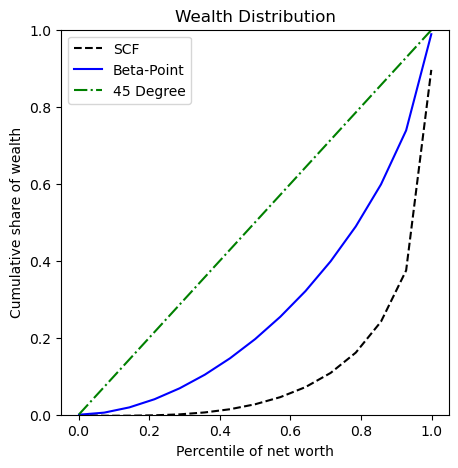

In [5]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Point")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_1")

## Time Preference Heterogeneneity

Our specific approach is to replace the assumption that all households have the same time
preference factor with an assumption that, for some dispersion $\nabla$, time
preference factors are distributed uniformly in the population between
$\grave{\Discount}-\nabla$ and $\grave{\Discount}+\nabla$ (for this reason, the model is referred to as the $\Discount$-Dist model). Then,
using simulations, we search for the values of $\grave{\Discount}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. Specifically, defining $w_{i}$ and $\omega _{i}$ as the proportion of total aggregate net worth held by the top $i$ percent in our model and in the data, respectively, we solve the following minimization problem:

$$
\{\grave{\Discount}, \nabla\}= \underset{\{{\Discount}, \nabla\}}{\text{argmin} }\Big(\sum_\text{i=20, 40, 60, 80}
  \big(w_{i}({\Discount}, \nabla)-\omega _{i}\big)^{2}\Big)^{1/2}
$$

subject to the constraint that the aggregate wealth (net worth)-to-output ratio in the model matches the aggregate
capital-to-output ratio from the perfect foresight model ($\KLev_{PF}/\YLev_{PF}$). When solving the problem for the FBS specification we shut down the aggregate shocks (practically, this does not affect the estimates given their small size).

$$\KLev / \YLev = \KLev_{PF} / \YLev_{PF}$$

The solution to this problem is $\{\grave{\Discount}, \nabla\}=\{0.9867, 0.0067\}$
, so that the discount factors are evenly spread roughly between 0.98 and 0.99. We call the optimal value of the objective function the 'Lorenz distance' and use it as a measure of fit of the models.

The introduction of even such a relatively modest amount of time
preference heterogeneity sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data.


In [6]:
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""
do_param_dist = True  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = True
do_tractable = False  #
os.chdir(path_to_models)

Beginning an estimation with the specification name PYbetaDistIndLiquid...
0.9448571428571428
0.9465714285714285
0.9482857142857143
0.95
0.9517142857142856
0.9534285714285714
0.9551428571428571


get_KY_ratio_difference tried center = 0.95 and got -6.081644553236843
0.9898571428571428
0.9915714285714284
0.9932857142857142
0.9949999999999999
0.9967142857142856
0.9984285714285713
1.000142857142857


get_KY_ratio_difference tried center = 0.995 and got 111.87225475789964
0.9471773205409154
0.9488916062552011
0.9506058919694869
0.9523201776837725
0.9540344633980582
0.955748749112344
0.9574630348266296


get_KY_ratio_difference tried center = 0.9523201776837725 and got -6.061271876164698
0.9685172316990291
0.9702315174133148
0.9719458031276006
0.9736600888418863
0.9753743745561719
0.9770886602704577
0.9788029459847434


get_KY_ratio_difference tried center = 0.9736600888418863 and got -5.692938141110104
0.979187187278086
0.9809014729923716
0.9826157587066574
0.9843300444209431
0.9860443301352287
0.9877586158495145
0.9894729015638002


get_KY_ratio_difference tried center = 0.9843300444209431 and got -3.017259851122707
0.9845221650676144
0.9862364507819
0.9879507364961858
0.9896650222104715
0.9913793079247571
0.9930935936390429
0.9948078793533286


get_KY_ratio_difference tried center = 0.9896650222104715 and got 16.764215772575135
0.9800009291139928
0.9817152148282785
0.9834295005425643
0.98514378625685
0.9868580719711356
0.9885723576854214
0.9902866433997071


get_KY_ratio_difference tried center = 0.98514378625685 and got -1.7501864024150722
0.9810186828563897
0.9827329685706754
0.9844472542849612
0.9861615399992468
0.9878758257135325
0.9895901114278183
0.9913043971421039


get_KY_ratio_difference tried center = 0.9861615399992468 and got 0.46104549117789073
0.9808064795251059
0.9825207652393916
0.9842350509536774
0.985949336667963
0.9876636223822487
0.9893779080965345
0.9910921938108201


get_KY_ratio_difference tried center = 0.985949336667963 and got -0.06573642418073256
0.9808329601004467
0.9825472458147324
0.9842615315290182
0.9859758172433039
0.9876901029575895
0.9894043886718753
0.991118674386161


get_KY_ratio_difference tried center = 0.9859758172433039 and got -0.002031605614891241
0.9808338008855634
0.982548086599849
0.9842623723141348
0.9859766580284205
0.9876909437427062
0.9894052294569919
0.9911195151712776


get_KY_ratio_difference tried center = 0.9859766580284205 and got -5.338092954332296e-07
0.9808343008855638
0.9825485865998494
0.9842628723141352
0.9859771580284209
0.9876914437427066
0.9894057294569923
0.991120015171278


get_KY_ratio_difference tried center = 0.9859771580284209 and got 0.0012075788609697824
0.9808338008855634
0.982548086599849
0.9842623723141348
0.9859766580284205
0.9876909437427062
0.9894052294569919
0.9911195151712776


find_lorenz_distance_at_target_KY tried spread = 0.006 and got 19.634158896939507
0.9431428571428571
0.9454285714285714
0.9477142857142856
0.95
0.9522857142857143
0.9545714285714285
0.9568571428571429


get_KY_ratio_difference tried center = 0.95 and got -6.08027235749887
0.9881428571428571
0.9904285714285713
0.9927142857142857
0.9949999999999999
0.9972857142857141
0.9995714285714284
1.0018571428571428


get_KY_ratio_difference tried center = 0.995 and got 154.26578114583674
0.9448492431131346
0.9471349573988489
0.9494206716845631
0.9517063859702775
0.9539921002559918
0.956277814541706
0.9585635288274204


get_KY_ratio_difference tried center = 0.9517063859702775 and got -6.0653003363644995
0.9664960501279958
0.9687817644137101
0.9710674786994243
0.9733531929851387
0.975638907270853
0.9779246215565672
0.9802103358422816


get_KY_ratio_difference tried center = 0.9733531929851387 and got -5.686958999221926
0.9773194536354264
0.9796051679211407
0.9818908822068549
0.9841765964925693
0.9864623107782836
0.9887480250639978
0.9910337393497122


get_KY_ratio_difference tried center = 0.9841765964925693 and got -1.066794976755336
0.9797323644809123
0.9820180787666266
0.9843037930523408
0.9865895073380552
0.9888752216237695
0.9911609359094837
0.9934466501951981


get_KY_ratio_difference tried center = 0.9865895073380552 and got 5.926816364417023
0.977687515434081
0.9799732297197953
0.9822589440055095
0.9845446582912238
0.9868303725769382
0.9891160868626524
0.9914018011483667


get_KY_ratio_difference tried center = 0.9845446582912238 and got -0.3098510660877398
0.9778306943021287
0.980116408587843
0.9824021228735572
0.9846878371592716
0.9869735514449859
0.9892592657307001
0.9915449800164144


get_KY_ratio_difference tried center = 0.9846878371592716 and got 0.00929301446307651
0.9778265251403843
0.9801122394260986
0.9823979537118128
0.9846836679975272
0.9869693822832415
0.9892550965689557
0.99154081085467


get_KY_ratio_difference tried center = 0.9846836679975272 and got -0.0002005262599089619
0.9778270251403847
0.980112739426099
0.9823984537118132
0.9846841679975276
0.9869698822832419
0.9892555965689561
0.9915413108546705


get_KY_ratio_difference tried center = 0.9846841679975276 and got 0.000937361763953426
0.9778265251403843
0.9801122394260986
0.9823979537118128
0.9846836679975272
0.9869693822832415
0.9892550965689557
0.99154081085467


find_lorenz_distance_at_target_KY tried spread = 0.008 and got 14.14948763096814
0.9403690845714285
0.9435793897142857
0.9467896948571428
0.95
0.9532103051428571
0.9564206102857142
0.9596309154285714


get_KY_ratio_difference tried center = 0.95 and got -6.077127635770037
0.9853690845714286
0.9885793897142857
0.9917896948571429
0.995
0.9982103051428571
1.0014206102857144
1.0046309154285713


get_KY_ratio_difference tried center = 0.995 and got 289.6734904351096
0.941293751256467
0.9445040563993241
0.9477143615421812
0.9509246666850384
0.9541349718278955
0.9573452769707527
0.9605555821136098


get_KY_ratio_difference tried center = 0.9509246666850384 and got -6.068934046422369
0.9633314179139478
0.966541723056805
0.9697520281996621
0.9729623333425192
0.9761726384853764
0.9793829436282335
0.9825932487710907


get_KY_ratio_difference tried center = 0.9729623333425192 and got -5.657536406698894
0.9743502512426883
0.9775605563855454
0.9807708615284025
0.9839811666712597
0.9871914718141168
0.990401776956974
0.9936120820998311


get_KY_ratio_difference tried center = 0.9839811666712597 and got 4.3865008011102695
0.9695380307954918
0.972748335938349
0.9759586410812061
0.9791689462240633
0.9823792513669204
0.9855895565097775
0.9887998616526347


get_KY_ratio_difference tried center = 0.9791689462240633 and got -4.308465361316193
0.9719225467004942
0.9751328518433513
0.9783431569862084
0.9815534621290656
0.9847637672719227
0.9879740724147799
0.991184377557637


get_KY_ratio_difference tried center = 0.9815534621290656 and got -1.5953829447545838
0.9729507581279928
0.97616106327085
0.9793713684137071
0.9825816735565642
0.9857919786994214
0.9890022838422785
0.9922125889851356


get_KY_ratio_difference tried center = 0.9825816735565642 and got 0.433986499296406
0.9727308721534282
0.9759411772962854
0.9791514824391425
0.9823617875819997
0.9855720927248568
0.9887823978677139
0.9919927030105711


get_KY_ratio_difference tried center = 0.9823617875819997 and got -0.054590156430933234
0.9727554406824559
0.975965745825313
0.9791760509681702
0.9823863561110273
0.9855966612538845
0.9888069663967416
0.9920172715395987


get_KY_ratio_difference tried center = 0.9823863561110273 and got -0.0015415261362461408
0.9727561520859366
0.9759664572287937
0.9791767623716509
0.982387067514508
0.9855973726573651
0.9888076778002223
0.9920179829430794


get_KY_ratio_difference tried center = 0.982387067514508 and got -6.320978052087867e-07
0.972756652085937
0.9759669572287941
0.9791772623716513
0.9823875675145084
0.9855978726573655
0.9888081778002227
0.9920184829430798


get_KY_ratio_difference tried center = 0.9823875675145084 and got 0.001082556762037612
0.9727561520859366
0.9759664572287937
0.9791767623716509
0.982387067514508
0.9855973726573651
0.9888076778002223
0.9920179829430794


find_lorenz_distance_at_target_KY tried spread = 0.011236068 and got 8.723174425658312
0.9382244880012295
0.9421496586674863
0.9460748293337431
0.95
0.9539251706662568
0.9578503413325136
0.9617755119987704


get_KY_ratio_difference tried center = 0.95 and got -6.073837204691546
0.9832244880012295
0.9871496586674864
0.9910748293337431
0.995
0.9989251706662569
1.0028503413325136
1.0067755119987705


get_KY_ratio_difference tried center = 0.995 and got 450.4818908031636
0.9388231502399089
0.9427483209061658
0.9466734915724225
0.9505986622386794
0.9545238329049363
0.958449003571193
0.9623741742374499


get_KY_ratio_difference tried center = 0.9505986622386794 and got -6.0684272057667155
0.9610238191205692
0.9649489897868261
0.9688741604530828
0.9727993311193397
0.9767245017855966
0.9806496724518533
0.9845748431181102


get_KY_ratio_difference tried center = 0.9727993311193397 and got -5.5986539450985005
0.9721241535608994
0.9760493242271563
0.979974494893413
0.9838996655596699
0.9878248362259268
0.9917500068921835
0.9956751775584404


get_KY_ratio_difference tried center = 0.9838996655596699 and got 12.130188603809094
0.9645292330264588
0.9684544036927156
0.9723795743589724
0.9763047450252292
0.9802299156914861
0.9841550863577428
0.9880802570239997


get_KY_ratio_difference tried center = 0.9763047450252292 and got -4.867228577680407
0.968326693293679
0.9722518639599359
0.9761770346261927
0.9801022052924495
0.9840273759587064
0.9879525466249631
0.99187771729122


get_KY_ratio_difference tried center = 0.9801022052924495 and got -0.8137168960853289
0.9689390791120667
0.9728642497783235
0.9767894204445803
0.9807145911108371
0.984639761777094
0.9885649324433508
0.9924901031096076


get_KY_ratio_difference tried center = 0.9807145911108371 and got 0.4457704461897585
0.9687223373550516
0.9726475080213085
0.9765726786875653
0.9804978493538221
0.984423020020079
0.9883481906863357
0.9922733613525926


get_KY_ratio_difference tried center = 0.9804978493538221 and got -0.02780831335060796
0.9687350643251148
0.9726602349913717
0.9765854056576284
0.9805105763238853
0.9844357469901421
0.9883609176563989
0.9922860883226557


get_KY_ratio_difference tried center = 0.9805105763238853 and got -0.0008733042398825219
0.9687355643251152
0.9726607349913721
0.9765859056576288
0.9805110763238857
0.9844362469901425
0.9883614176563993
0.9922865883226561


get_KY_ratio_difference tried center = 0.9805110763238857 and got 0.0002109077697962647
0.9687355643251152
0.9726607349913721
0.9765859056576288
0.9805110763238857
0.9844362469901425
0.9883614176563993
0.9922865883226561


find_lorenz_distance_at_target_KY tried spread = 0.01373809733189885 and got 6.199394697526963
0.9347544578343641
0.9398363052229094
0.9449181526114546
0.95
0.9550818473885453
0.9601636947770905
0.9652455421656359


get_KY_ratio_difference tried center = 0.95 and got -6.066724098193838
0.9797544578343641
0.9848363052229093
0.9899181526114547
0.9949999999999999
1.000081847388545
1.0051636947770903
1.0102455421656358


get_KY_ratio_difference tried center = 0.995 and got 573.209886426558
0.9352257397391719
0.9403075871277172
0.9453894345162625
0.9504712819048078
0.9555531292933531
0.9606349766818983
0.9657168240704437


get_KY_ratio_difference tried center = 0.9504712819048078 and got -6.062233165157473
0.957490098786768
0.9625719461753134
0.9676537935638586
0.972735640952404
0.9778174883409493
0.9828993357294945
0.9879811831180398


get_KY_ratio_difference tried center = 0.972735640952404 and got -5.028111839886524
0.968622278310566
0.9737041256991114
0.9787859730876566
0.9838678204762019
0.9889496678647473
0.9940315152532925
0.9991133626418378


get_KY_ratio_difference tried center = 0.9838678204762019 and got 39.301149214448834
0.9587527826740257
0.9638346300625711
0.9689164774511163
0.9739983248396616
0.979080172228207
0.9841620196167522
0.9892438670052975


get_KY_ratio_difference tried center = 0.9739983248396616 and got -4.23682923043819
0.9636875304922958
0.9687693778808412
0.9738512252693864
0.9789330726579317
0.9840149200464771
0.9890967674350223
0.9941786148235676


get_KY_ratio_difference tried center = 0.9789330726579317 and got 4.138432770622353
0.9612491444354417
0.9663309918239871
0.9714128392125323
0.9764946866010776
0.981576533989623
0.9866583813781682
0.9917402287667135


get_KY_ratio_difference tried center = 0.9764946866010776 and got -1.5041023255752712
0.961899132796389
0.9669809801849343
0.9720628275734795
0.9771446749620248
0.9822265223505702
0.9873083697391154
0.9923902171276607


get_KY_ratio_difference tried center = 0.9771446749620248 and got -0.40407004599391705
0.962116651951074
0.9671984993396193
0.9722803467281645
0.9773621941167099
0.9824440415052552
0.9875258888938004
0.9926077362823458


get_KY_ratio_difference tried center = 0.9773621941167099 and got 0.020177485867041156
0.9621063065999762
0.9671881539885215
0.9722700013770668
0.9773518487656121
0.9824336961541574
0.9875155435427027
0.992597390931248


get_KY_ratio_difference tried center = 0.9773518487656121 and got -0.0006954857931642522
0.9621068065999766
0.9671886539885219
0.9722705013770672
0.9773523487656125
0.9824341961541578
0.9875160435427031
0.9925978909312484


get_KY_ratio_difference tried center = 0.9773523487656125 and got 0.00031154336845951036
0.9621068065999766
0.9671886539885219
0.9722705013770672
0.9773523487656125
0.9824341961541578
0.9875160435427031
0.9925978909312484


find_lorenz_distance_at_target_KY tried spread = 0.017786465859908472 and got 3.7895870193546544
0.932447608701198
0.9382984058007987
0.9441492029003993
0.95
0.9558507970996006
0.9617015941992012
0.9675523912988019


get_KY_ratio_difference tried center = 0.95 and got -6.060534755393528
0.9774476087011981
0.9832984058007987
0.9891492029003993
0.995
1.0008507970996006
1.0067015941992012
1.012552391298802


get_KY_ratio_difference tried center = 0.995 and got 668.4302817250245
0.9328519493643013
0.938702746463902
0.9445535435635025
0.9504043406631032
0.9562551377627039
0.9621059348623044
0.9679567319619051


get_KY_ratio_difference tried center = 0.9504043406631032 and got -6.056493271889376
0.9551497790327497
0.9610005761323503
0.9668513732319509
0.9727021703315516
0.9785529674311523
0.9844037645307528
0.9902545616303535


get_KY_ratio_difference tried center = 0.9727021703315516 and got -3.4270377497875315
0.9662986938669739
0.9721494909665745
0.9780002880661751
0.9838510851657758
0.9897018822653765
0.995552679364977
1.0014034764645776


get_KY_ratio_difference tried center = 0.9838510851657758 and got 78.28038929432607
0.955617395666736
0.9614681927663367
0.9673189898659372
0.9731697869655379
0.9790205840651386
0.9848713811647392
0.9907221782643398


get_KY_ratio_difference tried center = 0.9731697869655379 and got -2.9401886153538124
0.9583392046448691
0.9641900017444698
0.9700407988440704
0.975891595943671
0.9817423930432717
0.9875931901428723
0.993443987242473


get_KY_ratio_difference tried center = 0.975891595943671 and got 1.5567521695163986
0.9573969680812981
0.9632477651808988
0.9690985622804994
0.9749493593801001
0.9808001564797008
0.9866509535793013
0.992501750678902


get_KY_ratio_difference tried center = 0.9749493593801001 and got -0.42749535334569533
0.9575999678321044
0.9634507649317051
0.9693015620313057
0.9751523591309064
0.981003156230507
0.9868539533301076
0.9927047504297083


get_KY_ratio_difference tried center = 0.9751523591309064 and got -0.04953035676731421
0.9576257496136419
0.9634765467132426
0.9693273438128431
0.9751781409124438
0.9810289380120445
0.9868797351116451
0.9927305322112457


get_KY_ratio_difference tried center = 0.9751781409124438 and got 0.00022081472710766548
0.9576252496136415
0.9634760467132422
0.9693268438128427
0.9751776409124434
0.9810284380120441
0.9868792351116447
0.9927300322112453


get_KY_ratio_difference tried center = 0.9751776409124434 and got -0.0007473610454189483
0.9576257496136419
0.9634765467132426
0.9693273438128431
0.9751781409124438
0.9810289380120445
0.9868797351116451
0.9927305322112457


find_lorenz_distance_at_target_KY tried spread = 0.020477789848602244 and got 3.247451348921011
0.9287150483708647
0.9358100322472431
0.9429050161236215
0.95
0.9570949838763784
0.9641899677527568
0.9712849516291352


get_KY_ratio_difference tried center = 0.95 and got -6.047339187004297
0.9737150483708648
0.9808100322472432
0.9879050161236215
0.9949999999999999
1.0020949838763782
1.0091899677527567
1.016284951629135


get_KY_ratio_difference tried center = 0.995 and got 698.8157868078284
0.9291011237000729
0.9361961075764513
0.9432910914528297
0.9503860753292082
0.9574810592055866
0.964576043081965
0.9716710269583434


get_KY_ratio_difference tried center = 0.9503860753292082 and got -6.043044947052052
0.9514080860354689
0.9585030699118473
0.9655980537882257
0.9726930376646041
0.9797880215409825
0.986883005417361
0.9939779892937394


get_KY_ratio_difference tried center = 0.9726930376646041 and got 2.491122350053823
0.9448966865630964
0.9519916704394749
0.9590866543158533
0.9661816381922317
0.9732766220686101
0.9803716059449885
0.9874665898213669


get_KY_ratio_difference tried center = 0.9661816381922317 and got -5.355751987641335
0.949340932662331
0.9564359165387094
0.9635309004150878
0.9706258842914662
0.9777208681678446
0.9848158520442231
0.9919108359206015


get_KY_ratio_difference tried center = 0.9706258842914662 and got -1.5593912052151424
0.9501367578696578
0.9572317417460362
0.9643267256224146
0.971421709498793
0.9785166933751714
0.9856116772515499
0.9927066611279283


get_KY_ratio_difference tried center = 0.971421709498793 and got -0.2729404648317404
0.950288931571803
0.9573839154481815
0.9644788993245599
0.9715738832009383
0.9786688670773167
0.9857638509536951
0.9928588348300735


get_KY_ratio_difference tried center = 0.9715738832009383 and got 0.006554865735813209
0.9502853627172392
0.9573803465936176
0.964475330469996
0.9715703143463744
0.9786652982227528
0.9857602820991312
0.9928552659755097


get_KY_ratio_difference tried center = 0.9715703143463744 and got -0.00013220811252789844
0.9502858627172396
0.957380846593618
0.9644758304699964
0.9715708143463748
0.9786657982227532
0.9857607820991316
0.9928557659755101


get_KY_ratio_difference tried center = 0.9715708143463748 and got 0.0008042540958292932
0.9502853627172392
0.9573803465936176
0.964475330469996
0.9715703143463744
0.9786652982227528
0.9857602820991312
0.9928552659755097


find_lorenz_distance_at_target_KY tried spread = 0.02483244356732438 and got 3.560880596139253
0.931021897562062
0.9373479317080413
0.9436739658540206
0.95
0.9563260341459793
0.9626520682919586
0.9689781024379379


get_KY_ratio_difference tried center = 0.95 and got -6.056014100442086
0.976021897562062
0.9823479317080414
0.9886739658540207
0.995
1.0013260341459793
1.0076520682919587
1.013978102437938


get_KY_ratio_difference tried center = 0.995 and got 681.6790260782448
0.9314181557408645
0.9377441898868438
0.9440702240328231
0.9503962581788025
0.9567222923247818
0.9630483264707611
0.9693743606167404


get_KY_ratio_difference tried center = 0.9503962581788025 and got -6.051905877724938
0.9537200266514633
0.9600460607974426
0.9663720949434219
0.9726981290894012
0.9790241632353806
0.9853501973813599
0.9916762315273392


get_KY_ratio_difference tried center = 0.9726981290894012 and got -1.810963625751719
0.9631600694443861
0.9694861035903655
0.9758121377363448
0.9821381718823241
0.9884642060283034
0.9947902401742827
1.0011162743202622


get_KY_ratio_difference tried center = 0.9821381718823241 and got 69.1940729694204
0.9539607923061729
0.9602868264521522
0.9666128605981316
0.9729388947441109
0.9792649288900902
0.9855909630360695
0.9919169971820488


get_KY_ratio_difference tried center = 0.9729388947441109 and got -1.465147797329359
0.9549597133336657
0.961285747479645
0.9676117816256243
0.9739378157716037
0.980263849917583
0.9865898840635623
0.9929159182095416


get_KY_ratio_difference tried center = 0.9739378157716037 and got 0.24771823605865162
0.9548152473041753
0.9611412814501546
0.967467315596134
0.9737933497421133
0.9801193838880926
0.9864454180340719
0.9927714521800513


get_KY_ratio_difference tried center = 0.9737933497421133 and got -0.032049411102497594
0.954831796934615
0.9611578310805943
0.9674838652265736
0.9738098993725529
0.9801359335185322
0.9864619676645116
0.9927880018104909


get_KY_ratio_difference tried center = 0.9738098993725529 and got -0.000639949229078951
0.9548322969346154
0.9611583310805947
0.967484365226574
0.9738103993725533
0.9801364335185326
0.986462467664512
0.9927885018104913


get_KY_ratio_difference tried center = 0.9738103993725533 and got 0.0003114134141508629
0.9548322969346154
0.9611583310805947
0.967484365226574
0.9738103993725533
0.9801364335185326
0.986462467664512
0.9927885018104913


find_lorenz_distance_at_target_KY tried spread = 0.022141119510927662 and got 3.2607768184192243
0.9333287466371969
0.9388858310914646
0.9444429155457322
0.95
0.9555570844542677
0.9611141689085353
0.966671253362803


get_KY_ratio_difference tried center = 0.95 and got -6.063053896266307
0.9783287466371969
0.9838858310914645
0.9894429155457323
0.9949999999999999
1.0005570844542675
1.0061141689085351
1.011671253362803


get_KY_ratio_difference tried center = 0.995 and got 642.4396334107854
0.9337494656730192
0.9393065501272869
0.9448636345815545
0.9504207190358223
0.95597780349009
0.9615348879443576
0.9670919723986253


get_KY_ratio_difference tried center = 0.9504207190358223 and got -6.058929132798922
0.9560391061551081
0.9615961906093758
0.9671532750636435
0.9727103595179112
0.9782674439721789
0.9838245284264465
0.9893816128807142


get_KY_ratio_difference tried center = 0.9727103595179112 and got -4.173267362441683
0.9671839263961526
0.9727410108504203
0.9782980953046879
0.9838551797589556
0.9894122642132234
0.994969348667491
1.0005264331217587


get_KY_ratio_difference tried center = 0.9838551797589556 and got 60.30628927705745
0.9567604249264555
0.9623175093807232
0.9678745938349909
0.9734316782892586
0.9789887627435263
0.9845458471977939
0.9901029316520616


get_KY_ratio_difference tried center = 0.9734316782892586 and got -3.5448114880280532
0.9606031543569736
0.9661602388112414
0.971717323265509
0.9772744077197767
0.9828314921740444
0.988388576628312
0.9939456610825798


get_KY_ratio_difference tried center = 0.9772744077197767 and got 3.064912404205165
0.9588212903503033
0.964378374804571
0.9699354592588386
0.9754925437131063
0.9810496281673741
0.9866067126216417
0.9921637970759094


get_KY_ratio_difference tried center = 0.9754925437131063 and got -0.9444957264602492
0.9592410438113096
0.9647981282655773
0.9703552127198449
0.9759122971741127
0.9814693816283804
0.987026466082648
0.9925835505369157


get_KY_ratio_difference tried center = 0.9759122971741127 and got -0.19810876073156436
0.9593456920917232
0.9649027765459909
0.9704598610002585
0.9760169454545262
0.9815740299087939
0.9871311143630616
0.9926881988173293


get_KY_ratio_difference tried center = 0.9760169454545262 and got 0.004181256117313126
0.9593435290523925
0.9649006135066602
0.9704576979609278
0.9760147824151956
0.9815718668694633
0.9871289513237309
0.9926860357779986


get_KY_ratio_difference tried center = 0.9760147824151956 and got -6.763443421675674e-05
0.9593440290523929
0.9649011135066606
0.9704581979609282
0.976015282415196
0.9815723668694637
0.9871294513237313
0.992686535777999


get_KY_ratio_difference tried center = 0.976015282415196 and got 0.0009142559514812021
0.9593435290523925
0.9649006135066602
0.9704576979609278
0.9760147824151956
0.9815718668694633
0.9871289513237309
0.9926860357779986


find_lorenz_distance_at_target_KY tried spread = 0.019449795589936838 and got 3.358673057660488
0.9318142722143367
0.9378761814762244
0.9439380907381122
0.95
0.9560619092618877
0.9621238185237755
0.9681857277856633


get_KY_ratio_difference tried center = 0.95 and got -6.058599168244882
0.9768142722143367
0.9828761814762245
0.9889380907381121
0.9949999999999999
1.0010619092618875
1.0071238185237754
1.013185727785663


get_KY_ratio_difference tried center = 0.995 and got 676.3095562015808
0.9322138174750959
0.9382757267369837
0.9443376359988714
0.9503995452607592
0.956461454522647
0.9625233637845347
0.9685852730464225


get_KY_ratio_difference tried center = 0.9503995452607592 and got -6.054541106471816
0.9545140448447164
0.9605759541066041
0.9666378633684919
0.9726997726303797
0.9787616818922674
0.9848235911541552
0.990885500416043


get_KY_ratio_difference tried center = 0.9726997726303797 and got -2.7791375145784905
0.9656641585295266
0.9717260677914143
0.9777879770533021
0.9838498863151899
0.9899117955770776
0.9959737048389654
1.002035614100853


get_KY_ratio_difference tried center = 0.9838498863151899 and got 94.38505724981039
0.9548329658146107
0.9608948750764985
0.9669567843383863
0.973018693600274
0.9790806028621618
0.9851425121240496
0.9912044213859373


get_KY_ratio_difference tried center = 0.973018693600274 and got -2.399630814694734
0.956799514252482
0.9628614235143698
0.9689233327762575
0.9749852420381453
0.9810471513000331
0.9871090605619208
0.9931709698238086


get_KY_ratio_difference tried center = 0.9749852420381453 and got 0.8475227434747676
0.9562862356232508
0.9623481448851385
0.9684100541470263
0.9744719634089141
0.9805338726708018
0.9865957819326896
0.9926576911945774


get_KY_ratio_difference tried center = 0.9744719634089141 and got -0.18987505755806922
0.9563801810790553
0.9624420903409431
0.9685039996028308
0.9745659088647186
0.9806278181266064
0.9866897273884941
0.9927516366503819


get_KY_ratio_difference tried center = 0.9745659088647186 and got -0.012349148077425376
0.9563866223065609
0.9624485315684487
0.9685104408303364
0.9745723500922242
0.980634259354112
0.9866961686159997
0.9927580778778875


get_KY_ratio_difference tried center = 0.9745723500922242 and got 3.2298746603487416e-05
0.9563861223065605
0.9624480315684483
0.968509940830336
0.9745718500922238
0.9806337593541116
0.9866956686159993
0.9927575778778871


get_KY_ratio_difference tried center = 0.9745718500922238 and got -0.0009275846986316338
0.9563866223065609
0.9624485315684487
0.9685104408303364
0.9745723500922242
0.980634259354112
0.9866961686159997
0.9927580778778875


find_lorenz_distance_at_target_KY tried spread = 0.021216682416607093 and got 3.22852538258721
0.9318291459170189
0.9378860972780126
0.9439430486390062
0.95
0.9560569513609937
0.9621139027219873
0.968170854082981


get_KY_ratio_difference tried center = 0.95 and got -6.058645971834647
0.9768291459170191
0.9828860972780128
0.9889430486390064
0.9950000000000001
1.0010569513609937
1.0071139027219875
1.0131708540829811


get_KY_ratio_difference tried center = 0.995 and got 676.2059308976427
0.9322287549220526
0.9382857062830463
0.9443426576440399
0.9503996090050336
0.9564565603660273
0.9625135117270209
0.9685704630880146


get_KY_ratio_difference tried center = 0.9503996090050336 and got -6.054588787919656
0.9545289504195358
0.9605859017805295
0.9666428531415231
0.9726998045025168
0.9787567558635105
0.9848137072245041
0.9908706585854978


get_KY_ratio_difference tried center = 0.9726998045025168 and got -2.79555666793921
0.9656790481682773
0.971735999529271
0.9777929508902646
0.9838499022512583
0.9899068536122521
0.9959638049732457
1.0020207563342394


get_KY_ratio_difference tried center = 0.9838499022512583 and got 93.97143551357033
0.9548510719343928
0.9609080232953865
0.9669649746563801
0.9730219260173738
0.9790788773783675
0.9851358287393611
0.9911927801003548


get_KY_ratio_difference tried center = 0.9730219260173738 and got -2.413478100416955
0.9568348688794119
0.9628918202404056
0.9689487716013993
0.975005722962393
0.9810626743233867
0.9871196256843803
0.993176577045374


get_KY_ratio_difference tried center = 0.975005722962393 and got 0.8613530880007669
0.9563130863733084
0.9623700377343021
0.9684269890952957
0.9744839404562894
0.9805408918172831
0.9865978431782767
0.9926547945392704


get_KY_ratio_difference tried center = 0.9744839404562894 and got -0.19415834016177858
0.9564090667886856
0.9624660181496794
0.968522969510673
0.9745799208716667
0.9806368722326604
0.986693823593654
0.9927507749546477


get_KY_ratio_difference tried center = 0.9745799208716667 and got -0.012828580503883025
0.956415757490314
0.9624727088513078
0.9685296602123014
0.9745866115732951
0.9806435629342888
0.9867005142952824
0.9927574656562761


get_KY_ratio_difference tried center = 0.9745866115732951 and got 3.323562147450332e-05
0.9564152574903136
0.9624722088513074
0.968529160212301
0.9745861115732947
0.9806430629342884
0.986700014295282
0.9927569656562757


get_KY_ratio_difference tried center = 0.9745861115732947 and got -0.0009268268681985603
0.956415757490314
0.9624727088513078
0.9685296602123014
0.9745866115732951
0.9806435629342888
0.9867005142952824
0.9927574656562761


find_lorenz_distance_at_target_KY tried spread = 0.021199329763477874 and got 3.2284695034255253
0.9318562441170082
0.9379041627446721
0.943952081372336
0.95
0.9560479186276639
0.9620958372553278
0.9681437558829917


get_KY_ratio_difference tried center = 0.95 and got -6.058731046947972
0.9768562441170083
0.9829041627446723
0.9889520813723361
0.9950000000000001
1.001047918627664
1.007095837255328
1.0131437558829919


get_KY_ratio_difference tried center = 0.995 and got 676.0171762724357
0.9322559692710372
0.9383038878987011
0.944351806526365
0.9503997251540289
0.9564476437816929
0.9624955624093567
0.9685434810370207


get_KY_ratio_difference tried center = 0.9503997251540289 and got -6.054675422680507
0.9545561066940227
0.9606040253216866
0.9666519439493505
0.9726998625770145
0.9787477812046784
0.9847956998323423
0.9908436184600062


get_KY_ratio_difference tried center = 0.9726998625770145 and got -2.825304593658097
0.9657061754055154
0.9717540940331794
0.9778020126608432
0.9838499312885072
0.9898978499161711
0.995945768543835
1.001993687171499


get_KY_ratio_difference tried center = 0.9838499312885072 and got 93.22213656080972
0.9548840939883382
0.9609320126160021
0.966979931243666
0.97302784987133
0.9790757684989939
0.9851236871266578
0.9911716057543217


get_KY_ratio_difference tried center = 0.97302784987133 and got -2.438546123782726
0.9568993662983034
0.9629472849259674
0.9689952035536312
0.9750431221812952
0.9810910408089591
0.987138959436623
0.993186878064287


get_KY_ratio_difference tried center = 0.9750431221812952 and got 0.8868368385846503
0.9563619191096691
0.962409837737333
0.9684577563649969
0.9745056749926608
0.9805535936203248
0.9866015122479886
0.9926494308756526


get_KY_ratio_difference tried center = 0.9745056749926608 and got -0.20213835787372503
0.9564616814297914
0.9625096000574553
0.9685575186851192
0.9746054373127832
0.9806533559404471
0.986701274568111
0.9927491931957749


get_KY_ratio_difference tried center = 0.9746054373127832 and got -0.013716718369918723
0.9564688333088776
0.9625167519365415
0.9685646705642054
0.9746125891918693
0.9806605078195333
0.9867084264471971
0.9927563450748611


get_KY_ratio_difference tried center = 0.9746125891918693 and got 3.427785036258513e-05
0.9564683333088771
0.9625162519365411
0.968564170564205
0.9746120891918689
0.9806600078195329
0.9867079264471967
0.9927558450748607


get_KY_ratio_difference tried center = 0.9746120891918689 and got -0.0009261130997932909
0.9564688333088776
0.9625167519365415
0.9685646705642054
0.9746125891918693
0.9806605078195333
0.9867084264471971
0.9927563450748611


find_lorenz_distance_at_target_KY tried spread = 0.0211677151968237 and got 3.228424743731521
0.9318591611671169
0.9379061074447446
0.9439530537223723
0.95
0.9560469462776277
0.9620938925552553
0.968140838832883


get_KY_ratio_difference tried center = 0.95 and got -6.058740193204567
0.9768591611671169
0.9829061074447446
0.9889530537223723
0.995
1.0010469462776277
1.0070938925552555
1.013140838832883


get_KY_ratio_difference tried center = 0.995 and got 675.9974110423692
0.9322588985028191
0.9383058447804468
0.9443527910580745
0.9503997373357022
0.9564466836133299
0.9624936298909575
0.9685405761685852


get_KY_ratio_difference tried center = 0.9503997373357022 and got -6.05468473796388
0.954559029834968
0.9606059761125957
0.9666529223902234
0.9726998686678511
0.9787468149454788
0.9847937612231065
0.9908407075007342


get_KY_ratio_difference tried center = 0.9726998686678511 and got -2.8284936613324434
0.9657090955010424
0.9717560417786701
0.9778029880562978
0.9838499343339255
0.9898968806115532
0.9959438268891809
1.0019907731668085


get_KY_ratio_difference tried center = 0.9838499343339255 and got 93.14179724312486
0.954887651221469
0.9609345974990967
0.9669815437767244
0.9730284900543521
0.9790754363319798
0.9851223826096075
0.9911693288872352


get_KY_ratio_difference tried center = 0.9730284900543521 and got -2.4412318362412515
0.9569063149751004
0.9629532612527281
0.9690002075303558
0.9750471538079835
0.9810941000856112
0.9871410463632388
0.9931879926408665


get_KY_ratio_difference tried center = 0.9750471538079835 and got 0.889600284532226
0.9563671692648121
0.9624141155424398
0.9684610618200675
0.9745080080976952
0.9805549543753229
0.9866019006529506
0.9926488469305783


get_KY_ratio_difference tried center = 0.9745080080976952 and got -0.20300580425966697
0.9564673423369311
0.9625142886145588
0.9685612348921865
0.9746081811698142
0.9806551274474419
0.9867020737250696
0.9927490200026973


get_KY_ratio_difference tried center = 0.9746081811698142 and got -0.013817305670764668
0.9564745465408695
0.9625214928184972
0.9685684390961249
0.9746153853737526
0.9806623316513803
0.986709277929008
0.9927562242066357


get_KY_ratio_difference tried center = 0.9746153853737526 and got 3.4495797439859643e-05
0.9564740465408691
0.9625209928184968
0.9685679390961245
0.9746148853737522
0.9806618316513799
0.9867087779290076
0.9927557242066353


get_KY_ratio_difference tried center = 0.9746148853737522 and got -0.0009259312631826333
0.9564745465408695
0.9625214928184972
0.9685684390961249
0.9746153853737526
0.9806623316513803
0.986709277929008
0.9927562242066357


find_lorenz_distance_at_target_KY tried spread = 0.02116431197169698 and got 3.2284245246637115
0.9318609752595716
0.9379073168397144
0.9439536584198571
0.95
0.9560463415801428
0.9620926831602855
0.9681390247404283


get_KY_ratio_difference tried center = 0.95 and got -6.058745880041908
0.9768609752595716
0.9829073168397144
0.9889536584198572
0.995
1.0010463415801427
1.0070926831602856
1.0131390247404284


get_KY_ratio_difference tried center = 0.995 and got 675.9846702275511
0.9322607204343845
0.9383070620145273
0.94435340359467
0.9503997451748128
0.9564460867549557
0.9624924283350984
0.9685387699152412


get_KY_ratio_difference tried center = 0.9503997451748128 and got -6.054690527195811
0.954560847846978
0.9606071894271209
0.9666535310072636
0.9726998725874064
0.9787462141675493
0.984792555747692
0.9908388973278348


get_KY_ratio_difference tried center = 0.9726998725874064 and got -2.830475630229566
0.9657109115532747
0.9717572531334175
0.9778035947135604
0.9838499362937032
0.989896277873846
0.9959426194539889
1.0019889610341317


get_KY_ratio_difference tried center = 0.9838499362937032 and got 93.09175407512285
0.9548898642146451
0.9609362057947879
0.9669825473749306
0.9730288889550734
0.9790752305352163
0.985121572115359
0.9911679136955018


get_KY_ratio_difference tried center = 0.9730288889550734 and got -2.442900345164932
0.9569106368667721
0.962956978446915
0.9690033200270577
0.9750496616072005
0.9810960031873434
0.9871423447674861
0.9931886863476289


get_KY_ratio_difference tried center = 0.9750496616072005 and got 0.8913208580033034
0.9563704337115609
0.9624167752917038
0.9684631168718465
0.9745094584519893
0.9805558000321322
0.9866021416122749
0.9926484831924177


get_KY_ratio_difference tried center = 0.9745094584519893 and got -0.2035462615710406
0.9564708626410322
0.962517204221175
0.9685635458013178
0.9746098873814606
0.9806562289616034
0.9867025705417461
0.992748912121889


get_KY_ratio_difference tried center = 0.9746098873814606 and got -0.013879258632584879
0.9564780990447616
0.9625244406249044
0.9685707822050471
0.9746171237851899
0.9806634653653328
0.9867098069454755
0.9927561485256183


get_KY_ratio_difference tried center = 0.9746171237851899 and got 3.3709114751978575e-05
0.9564775990447612
0.962523940624904
0.9685702822050467
0.9746166237851895
0.9806629653653324
0.9867093069454751
0.9927556485256179


get_KY_ratio_difference tried center = 0.9746166237851895 and got -0.0009267399245178609
0.9564780990447616
0.9625244406249044
0.9685707822050471
0.9746171237851899
0.9806634653653328
0.9867098069454755
0.9927561485256183


find_lorenz_distance_at_target_KY tried spread = 0.021162195530499812 and got 3.2284250653748625
0.9564762849523069
0.9625232312299346
0.9685701775075622
0.9746171237851899
0.9806640700628176
0.9867110163404453
0.992757962618073


Estimate is center=0.9746171237851899, spread=0.02116431197169698, took 2448.6780200004578 seconds.
Running in interactive shell (Jupyter notebook or spyder)


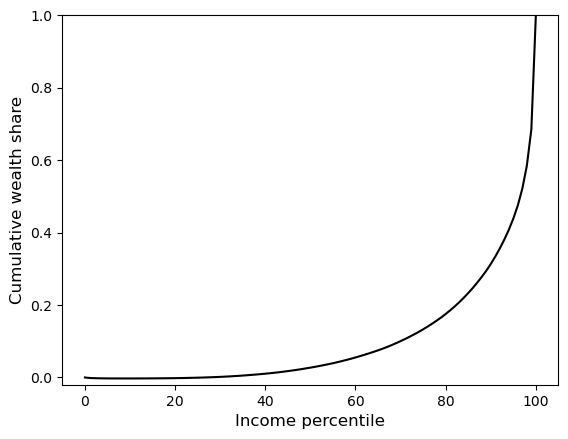

Estimate is center=0.9746171237851899, spread=0.02116431197169698
Lorenz distance is 3.227610031700354
Average MPC for all consumers is 0.443
Average MPC in the top percentile of W/Y is 0.053
Average MPC in the top decile of W/Y is 0.056
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.278
Average MPC in the middle quintile of W/Y is 0.467
Average MPC in the fourth quintile of W/Y is 0.596
Average MPC in the bottom quintile of W/Y is 0.803
Average MPC in the top percentile of y is 0.422
Average MPC in the top decile of y is 0.407
Average MPC in the top quintile of y is 0.410
Average MPC in the second quintile of y is 0.436
Average MPC in the middle quintile of y is 0.447
Average MPC in the fourth quintile of y is 0.429
Average MPC in the bottom quintile of y is 0.494
Average MPC for the employed is 0.428
Average MPC for the unemployed is 0.642
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
49.518% are in t

In [7]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, Params)

In [8]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

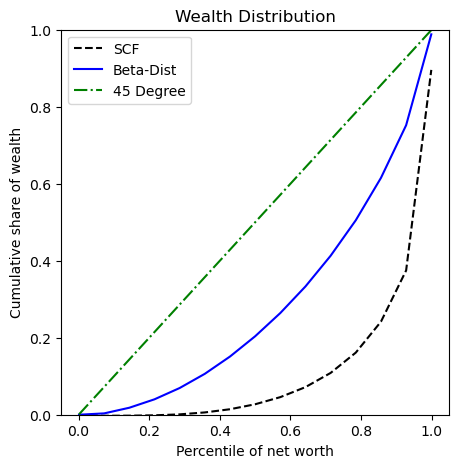

In [9]:
# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Dist")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_2")